This notebook can be found in the repository
 https://github.com/cmarasinou/WALLE-RL
 
We build a gridworld environment and agent and use Q-learning to make the agent learn.

The environment can be any size and have arbitrary obstacles and terminal states.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
np.random.seed(0)
random.seed(0)

# 1. The transition model

In [2]:
def generate_transition_model(h,w, 
                              terminal_state_locs, 
                              impossible_state_locs, 
                              p_forward = 0.8, 
                              actions= np.array([(0,-1),(0,+1),(-1,0),(+1,0)], dtype=int)):
    '''Defines the transition matrix for a general Gridworld
    Args:
        h (int): height of the Gridworld
        w (int): width of the Gridworld
        terminal_state_locs (np.array of ints, dims: 2 x n_terminal_states): the 
            locations of the terminal states on the grid  
        impossible_state_locs (np.array of ints, dims: 2 x n_impossible_states): the 
            locations of the interior walls on the grid  
        p_forward (float, optional): probability of obeying the action signal and moving forward
        actions (np.array of ints, dims: 2 x n_actions, optional): actions operations
            on state locations, the default corresponds to [LEFT, RIGHT, DOWN, UP]
    
    Returns:
        P (np.array of floats, dims: n_states x n_actions x n_states): Tensor giving the 
            transition model P(s',a,s) (with the index order described here)
    '''
    n_states = h*w
    n_actions = len(actions)
    
    # State locations map
    s_locs = np.array([(x,y) for x in range(0,h) for y in range(0,w)])
    
    terminal_states = [state_index(h,w,l) for l in terminal_state_locs]
    impossible_states = [state_index(h,w,l) for l in impossible_state_locs]
    
    # Initialize to zero
    P = np.zeros((n_states, n_actions, n_states))
    
    
    
    # Generate Transitions
    for s in range(n_states):
        # For states that can't be reached
        if s in impossible_states+terminal_states:
                continue
        for a in range(n_actions):
            sLoc = s_locs[s]
            act = actions[a]
            act2, act3 = 1-np.abs(act),-(1-np.abs(act))
            acts = (act,act2,act3)
            probs = (p_forward, (1-p_forward)/2.,(1-p_forward)/2.)
            for aa, pp in zip(acts, probs):
                spLoc = sLoc+aa
                if out_of_bounds(h,w,spLoc, impossible_states):
                    spLoc = sLoc
                sp = state_index(h,w,spLoc)
                P[sp,a,s] += pp
    
    return P

def out_of_bounds(h,w,state_location, impossible_states):
    '''Determines whether given state out of bounds'''
    if state_location[0] in range(0,h) and state_location[1] in range(0,w):
        if state_index(h,w,state_location) in impossible_states:
            return True
        return False
    else:
        return True
    
    
def state_index(h,w,s_loc):
    '''Maps a state location (tuple) to the state value (integer)'''
    return s_loc[0]*w+s_loc[1]

## Testing the transition model

In [3]:
height, width = 3, 4
terminalStates = np.array([(2,3),(1,3)],dtype=int)
wallStates = np.array([(1,1)], dtype=int)
Ptest = generate_transition_model(height,width,terminalStates, wallStates)

In [4]:
# sum of propabilities check. Summing over s'
Ptest.sum(0)

array([[1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.]])

Other than the terminal and wall states we get probability to sum up to 1

# 2. The Environment

In [5]:
class GridWorldEnv():
    '''Creates a Gridworld environment
    Args:
        h (int): height of the Gridworld
        w (int): width of the Gridworld
        rewards_matrix (np.array of floats, dims: h x w)
        terminal_state_locs (np.array of ints, dims: 2 x n_terminal_states): the 
            locations of the terminal states on the grid  
        impossible_state_locs (np.array of ints, dims: 2 x n_impossible_states): the 
            locations of the interior walls on the grid  
        p_forward (float, optional): probability of obeying the action signal and moving forward
        actions (np.array of ints, dims: 2 x n_actions, optional): actions operations
            on state locations, the default corresponds to [LEFT, RIGHT, DOWN, UP]
        initial_state (int or str, optional): state at which environment is initialized
            can be int corresponding to number of state or str='random'
    '''
    def __init__(self,h,w, 
                 rewards_matrix, 
                 terminal_state_locs, 
                 impossible_state_locs, 
                 p_forward=0.8,
                 actions=np.array([(0,-1),(0,+1),(-1,0),(+1,0)], dtype=int),
                 initial_state=0):

        self.n_states = h*w
        self.h = h # world height
        self.w = w #world width
        
        # define states
        self.initial_state = initial_state 
        self.current_state= initial_state
        self.s_locs = np.array([(x,y) for x in range(0,h) for y in range(0,w)])
        self.states = [state_index(h,w,l) for l in self.s_locs]
        self.terminal_state_locs = terminal_state_locs
        self.impossible_state_locs = impossible_state_locs
        self.terminal_states = [state_index(h,w,l) for l in terminal_state_locs]
        self.impossible_states = [state_index(h,w,l) for l in impossible_state_locs]

        self.regular_states = self.states.copy()
        for s in self.terminal_states+self.impossible_states:
            self.regular_states.remove(s)
        if initial_state == 'random':
            self.current_state = random.choice(self.regular_states)
        
        # define actions
        self.n_actions = len(actions)
        self.actions = actions
        
        # define rewards
        self.rewards = rewards_matrix.ravel()
        self.initial_reward = self.rewards[self.current_state]
        
        # define transition model
        self.p_forward = p_forward
        self.transition_model = generate_transition_model(h,w, 
                                                          terminal_state_locs, 
                                                          impossible_state_locs,
                                                          p_forward)

        
    def step(self, a):
        '''Performs a transition given an action
            a (int): the action's index
        Returns:
            current_state (int)
            reward (float)
            Bool: If True episode finished and environment re-initialized
        '''
        # transition to new state
        self.current_state = np.random.choice(self.n_states, 
                     p=self.transition_model[:,a,self.current_state])
        if self.current_state in self.terminal_states:
            end_state = self.current_state
            reward = self.rewards[end_state]
            #Reinitialize
            if self.initial_state == 'random':
                self.current_state = random.choice(self.regular_states)
            else:
                self.current_state = self.initial_state
            return end_state, reward, True # Last bool indicates that episode finished
                
        return self.current_state, self.rewards[self.current_state], False     

## Testing the Environment

In [6]:
height, width = 3, 4
terminalStates = np.array([(2,3),(1,3)],dtype=int)
wallStates = np.array([(1,1)], dtype=int)
rewardsMatrix = np.array([ (-0.04, -0.04, -0.04, -0.04),
                           (-0.04,  0.0,  -0.04, -1.0),
                           (-0.04, -0.04, -0.04,  1.0)])

env = GridWorldEnv(3,4, rewardsMatrix, terminalStates,  wallStates)

In [7]:
# Applying many consecutive actions
for i in range(0,5):
    print(env.step(1))

(1, -0.04, False)
(2, -0.04, False)
(3, -0.04, False)
(3, -0.04, False)
(3, -0.04, False)


Environment responds. Episodes can be terminated and environment resets.

Let's check on the map of the states and state locations

In [8]:
env.actions

array([[ 0, -1],
       [ 0,  1],
       [-1,  0],
       [ 1,  0]])

In [9]:
env.states

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [10]:
env.s_locs

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [2, 0],
       [2, 1],
       [2, 2],
       [2, 3]])

# 3. The Agent

In [11]:
class GridWorldAgent():
    '''Creates a Gridworld agent
    Args:
        policy_matrix (np.array of ints, dims: h x w): the initial policy 
        actions (np.array of ints, dims: 2 x n_actions, optional): actions operations
            on state locations, the default corresponds to [LEFT, RIGHT, DOWN, UP]
        action_symbols (np.array of ints, dims: 1 x n_actions, optional):
            corresponding action symbols for rendering
    '''
    def __init__(self,
                 policy_matrix, 
                 actions=np.array([(0,-1),(0,+1),(-1,0),(+1,0)]),
                 action_symbols = np.array(['<','>','^','v']),
                ):
        
        #define actions
        self.n_actions = len(actions)
        self.actions = actions
        self.action_symbols = action_symbols
        
        # Defining policy
        if policy_matrix.dtype==int:
            self.policy = policy_matrix.ravel()
        else:
            # when policy is given in symbol notation
            self.policy = self.translate_policy(policy_matrix)
        self.h, self.w = policy_matrix.shape
        
    def translate_policy(self,policy_symbols_matrix):
        '''Gets policy in symbols. Outputs policy as array of integers'''
        policy_symbols = policy_symbols_matrix.ravel()
        policy = np.zeros_like(policy_symbols, dtype=int)
        for i, symbol in enumerate(policy_symbols):
            if symbol is None:
                policy[i] = -1
            else:
                policy[i] = np.argmax(self.action_symbols==symbol)

        return policy

    def render_policy(self, mask_states = [], custom_policy = None):
        '''Prints symbolic version of current policy'''
        if custom_policy is not None:
            policy_to_render = custom_policy
        else:
            policy_to_render = self.policy
        policy_render = [self.action_symbols[idx] if idx in range(0,len(self.actions)) else '*'\
                    for idx in policy_to_render]
        if mask_states is not None:
            for state in mask_states:
                policy_render[state] = '*'
        policy_render = np.array(policy_render).reshape(self.h,self.w)
        print(policy_render)
        print('\n')
    
    def step(self, state, epsilon = None):
        '''Agent decides an action given a policy
        Args:
            state (int)
            epsilon (float, optional, 0.0-1.0): greediness
        Returns:
            action (int)
        '''
        action = self.policy[state]
        if epsilon is not None:
            sigma = random.random()
            if sigma <= epsilon:
                # choose action randomly
                actions = list(range(0,self.n_actions))
                actions.remove(action)
                action = random.choice(actions)
        return action

## Testing the Agent

In [12]:
policy_matrix = np.zeros((3,4),dtype=int)
agent = GridWorldAgent(policy_matrix)
agent.policy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
agent.render_policy()

[['<' '<' '<' '<']
 ['<' '<' '<' '<']
 ['<' '<' '<' '<']]




In [14]:
policy_symbols = np.array([['v' ,'<', '<' ,'<'],
                           ['v', None ,'v', None],
                           ['>' ,'>', '>', None]])
agent = GridWorldAgent(policy_symbols)
agent.policy

array([ 3,  0,  0,  0,  3, -1,  3, -1,  1,  1,  1, -1])

In [15]:
agent.step(5)

-1

In [16]:
agent.render_policy()

[['v' '<' '<' '<']
 ['v' '*' 'v' '*']
 ['>' '>' '>' '*']]




# 4. Q-learning

In [17]:
def initialize():
    '''Initializes agent, environment
    '''
    h, w = 3,4
    n_states = h*w
    n_actions = 4
    terminalStates = np.array([(2,3),(1,3)],dtype=int)
    wallStates = np.array([(1,1)], dtype=int)
    rewardsMatrix = np.array([ (-0.04, -0.04, -0.04, -0.04),
                               (-0.04,  0.0,  -0.04, -1.0),
                               (-0.04, -0.04, -0.04,  1.0)])
    q = np.zeros((n_states,n_actions))
    policy_matrix = np.random.randint(0,4,(3,4),dtype=int)
    agent = GridWorldAgent(policy_matrix)
    env = GridWorldEnv(3,4, rewardsMatrix, terminalStates,  wallStates, initial_state='random', p_forward=0.8)
    state = env.current_state
    reward = env.initial_reward
    episode_finished=False
    return agent, env, state, reward, episode_finished

In [18]:
def update_q(q, alpha, gamma, s, a, rp, sp):
    '''Applying q-learning update
    Args:
        q (np.array of floats, dims: n_states x n_actions) 
    Returns:
        q (np.array of floats, dims: n_states x n_actions): updated q
    '''
    q[s, a] = q[s, a]+alpha*(rp+gamma*q[sp,:].max()- q[s, a])
    return q

def update_policy(q):
    '''Given the q-matrix gives back the policy
    Args:
        q (np.array of floats, dims: n_states x n_actions) 
    Returns:
        policy (np.array of ints, dims: n_states): ints represent actions
    '''
    policy = q.argmax(axis = 1)
    return policy

def qlearning(convergence_criterion = 30000, alpha=0.1, gamma=0.999, epsilon=None):
    '''Performs qlearning
    Args:
        convergence_criterion (int, optional): number of iterations policy should
            stay the same for algorithm to finish
        alpha (float, optional)
        gamma (float, optional)
        epsilon (float, optional)
    Returns:
        agent and q_values
    '''
    n_iters = 0
    same_policy_iter = 0
    n_episodes = 0
    q = np.zeros((12,4))
    q_values = list()
    agent, env, s, r, episode_finished = initialize()
    no_action_states = env.impossible_states + env.terminal_states
    print('Iteration {} ---- Current policy same for {} iterations'.format(n_iters, same_policy_iter))
    agent.render_policy(mask_states=no_action_states)
    while same_policy_iter < convergence_criterion:
        a = agent.step(s, epsilon=epsilon)
        sp, rp, episode_finished = env.step(a)
        q = update_q(q, alpha, gamma, s, a, rp, sp)
        previous_policy = agent.policy

        agent.policy = update_policy(q)
        s, r = sp, rp
        current_policy = agent.policy
        
        #previous_policy = previous_policy.ravel()
        #previous_policy[no_action_states] = 0
        #current_policy = current_policy.ravel()
        #current_policy[no_action_states] = 0
    
        
        if np.array_equal(previous_policy, agent.policy):
            same_policy_iter += 1
        else:
            same_policy_iter = 0
        n_iters += 1
        q_values.append(q.mean())
        if n_iters%50000 == 0:
            print('Iteration {} ---- Current policy same for {} iterations'.format(n_iters, same_policy_iter))
            agent.render_policy(mask_states=no_action_states)
        if episode_finished:
            n_episodes += 1
            s, r = env.current_state, env.initial_reward
    print('Final iteration number {}'.format(n_iters))
    print('Final policy')
    agent.render_policy(mask_states=no_action_states)
    return agent, q_values

In [19]:
agent,q_values = qlearning(epsilon=0.005, alpha=0.05, gamma=0.9)

Iteration 0 ---- Current policy same for 0 iterations
[['>' '^' '<' 'v']
 ['^' '*' '<' '*']
 ['^' '>' '^' '*']]


Final iteration number 30907
Final policy
[['v' '>' 'v' '<']
 ['v' '*' 'v' '*']
 ['>' '>' '>' '*']]




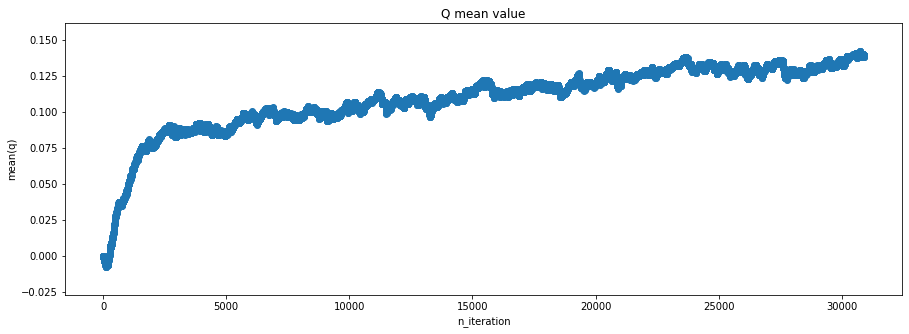

In [20]:
plt.figure(figsize=(15,5))
plt.scatter(range(0,len(q_values)),q_values)
plt.title('Q mean value')
plt.xlabel('n_iteration')
plt.ylabel('mean(q)')
plt.show()